## Introduction
In this notebook we will work with both the Exploration wellbore and the lithostratigraphy datasets from Norwegian Petroleum Directorate (NPD). The wellbore datasets are public domain. They are available here: https://data.norge.no/data/oljedirektoratet/br%C3%B8nnbane-wellbore. 

The datasets are available via an API which we will use. <br>

### Description of the different data 'wrangling' steps, until ultimately generating a shapefile (displaying on map):

We are first going to get the Exploration dataset, select columns and the wells for North Sea and Norwegian Sea only.

The lithostratigraphy dataset has information about Formations and Groups for each well. It means that in this dataset, each well will be represented by several rows, each row being one Formation with top and bottom depths. We are also going to select specific columns and only North Sea and Norwegian Sea areas. <br>

We are going to merge a selection of columns from the Exploration dataset together with the lithostratigraphy dataset.<br>

The lithostratigraphy dataset does not have Geological ages (Paleocene, Cretaceous, Jurassic, Triassic, Permian). We created a new table for Groups with matching Ages, before adding this information to our lithostratigraphy dataset (using pandas 'map'). <br>

The resulting is a dataframe for all Explorations wells in North Sea and Norwegian Sea, with Formation, Group and Age for each row. Each row also has coordinates, which will allow us to export to a point SHAPEFILE and examine our dataset in a geospatial context, here we are using MAPBOX.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import json
import re

import geopandas
from shapely.geometry import Point
from IPython.display import IFrame

from mapboxgl.utils import *
from mapboxgl.viz import *

import altair as alt
import seaborn as sns
# add the line below if you use notebooks and comment it if you use jupyter lab
# alt.renderers.enable('notebook')

#### API connection - check for status
Make a general get request, print out status code.
Status code = 200 means API connection is up and running.

In [3]:
requests.get('http://data.norge.no/api/dcat/870917732/data.json')

<Response [200]>

#### Get request - Exploration dataset
The dataset is paginated. The first page will tell us how many pages there are in total, and how many rows for the whole dataset. We go through all the page of the dataset and create a pandas dataframe from the json file.

In [4]:
dataset_explo = requests.get('http://hotell.difi.no/api/json/npd/wellbore/exploration?page=1')
json_dataset_explo = dataset_explo.json()

In [5]:
print(f'number of pages: {json_dataset_explo["pages"]}')
print(f'number of rows:  {json_dataset_explo["posts"]}')

number of pages: 20
number of rows:  1917


In [6]:
url_dataset ='http://hotell.difi.no/api/json/npd/wellbore/exploration'

def get_all_dataset():
    '''looping through all pages,
    append in JSON dictionary,
    create dataframe
    '''
    
    page = json_dataset_explo['pages']
    all_data_list = []
    for i in range(0, page):
        url = url_dataset + f'?page={i+1}'
        dataset_all = requests.get(url)
        dataset_all_json = dataset_all.json()
        number_of_entries = len(dataset_all_json['entries'])

        for entry in range(0, number_of_entries):
            all_data_list.append(dataset_all_json['entries'][entry])

    df_all_explo = pd.DataFrame(all_data_list)
    return df_all_explo

In [7]:
df_all_explo = get_all_dataset()
df_all_explo.shape

(1917, 87)

#### Select columns out in a new dataframe (from 81 columns down to 22)

In [8]:
df_all_explo_sel_col = df_all_explo.filter(['wlbWellboreName', 'wlbEwDesDeg','wlbNsDecDeg', 'wlbEntryYear',
                                                'wlbCompletionYear','wlbEwUtm','wlbNsUtm','wlbUtmZone',
                                                'wlbContent', 'wlbDiscoveryWellbore',
                                                'wlbTotalDepth','wlbAgeAtTd','wlbFormationAtTd',
                                                'wlbAgeWithHc1', 'wlbAgeWithHc2', 'wlbAgeWithHc3',
                                                'wlbFormationWithHc1', 'wlbFormationWithHc2', 'wlbFormationWithHc3',
                                                'wlbDrillingOperator', 'wlbMainArea', 'datesyncNPD'],
                                                axis=1)

#### We select wells only within North Sea and Norwegian Sea areas

In [9]:
df_explo_NTS_NS = df_all_explo_sel_col.loc[df_all_explo_sel_col['wlbMainArea'].isin(['NORTH SEA','NORWEGIAN SEA'])]
df_explo_NTS_NS.shape

(1754, 22)

In [10]:
df_explo_NTS_NS.head()

,wlbWellboreName,wlbEwDesDeg,wlbNsDecDeg,wlbEntryYear,wlbCompletionYear,wlbEwUtm,wlbNsUtm,wlbUtmZone,wlbContent,wlbDiscoveryWellbore,...,wlbFormationAtTd,wlbAgeWithHc1,wlbAgeWithHc2,wlbAgeWithHc3,wlbFormationWithHc1,wlbFormationWithHc2,wlbFormationWithHc3,wlbDrillingOperator,wlbMainArea,datesyncNPD
0,1/2-1,2.476583,56.887519,1989,1989,468106.29,6305128.26,31,OIL,YES,...,TOR FM,PALEOCENE,,,FORTIES FM,,,Phillips Petroleum Norsk AS,NORTH SEA,04.10.2019
1,1/2-2,2.496572,56.992222,2005,2006,469410.10,6316774.33,31,OIL SHOWS,NO,...,EKOFISK FM,,,,,,,Paladin Resources Norge AS,NORTH SEA,04.10.2019
2,1/3-1,2.851389,56.855833,1968,1968,490936.87,6301488.86,31,GAS,YES,...,ZECHSTEIN GP,LATE CRETACEOUS,EARLY CRETACEOUS,,TOR FM,CROMER KNOLL GP,,A/S Norske Shell,NORTH SEA,04.10.2019
3,1/3-2,2.750000,56.936111,1969,1969,484786.28,6310443.20,31,DRY,NO,...,SOLA FM,,,,,,,A/S Norske Shell,NORTH SEA,04.10.2019
4,1/3-3,2.981681,56.952378,1982,1983,498885.66,6312226.32,31,OIL,YES,...,ZECHSTEIN GP,LATE JURASSIC,,,ULA FM,,,Elf Petroleum Norge AS,NORTH SEA,04.10.2019


---

#### Get request - Lithostratigraphy dataset
The dataset is paginated. The first page will tell us how many pages there are in total, and how many rows for the whole dataset. We go through all the page of the dataset and create a pandas dataframe from the json file.

In [11]:
dataset_strati = requests.get('http://hotell.difi.no/api/json/npd/wellbore/with-lithostratigraphy?page=1')
json_dataset_strati = dataset_strati.json()

In [12]:
print(f'number of pages: {json_dataset_strati["pages"]}')
print(f'number of rows:  {json_dataset_strati["posts"]}')

number of pages: 360
number of rows:  35904


In [13]:
url_dataset ='http://hotell.difi.no/api/json/npd/wellbore/with-lithostratigraphy'

def get_all_dataset():
    '''looping through all pages,
    append in JSON dictionary,
    create dataframe
    '''
    
    page = json_dataset_strati['pages']
    all_data_list = []
    for i in range(0, page):
        url = url_dataset + f'?page={i+1}'
        dataset_all = requests.get(url)
        dataset_all_json = dataset_all.json()
        number_of_entries = len(dataset_all_json['entries'])

        for entry in range(0, number_of_entries):
            all_data_list.append(dataset_all_json['entries'][entry])

    df_all_explo_strati = pd.DataFrame(all_data_list)
    return df_all_explo_strati

In [14]:
df_all_explo_strati = get_all_dataset()
df_all_explo_strati.shape

(35904, 11)

#### Re-arrange colums to make it more readable

In [15]:
df_all_explo_strati = df_all_explo_strati[['wlbName', 'wlbNpdidWellbore', 'lsuTopDepth','lsuBottomDepth',
                                           'lsuName', 'lsuNameParent', 'lsuNpdidLithoStrat',
                                           'lsuNpdidLithoStratParent', 'lsuLevel',
                                           'IsuWellboreUpdatedDate', 'datesyncNPD']]

In [16]:
df_all_explo_strati.head()

,wlbName,wlbNpdidWellbore,lsuTopDepth,lsuBottomDepth,lsuName,lsuNameParent,lsuNpdidLithoStrat,lsuNpdidLithoStratParent,lsuLevel,IsuWellboreUpdatedDate,datesyncNPD
0,9/8-1,145,1597,1625,BLODØKS FM,SHETLAND GP,13,143,FORMATION,03.10.2019,04.10.2019
1,9/8-1,145,1922,2109,SANDNES FM,VESTLAND GP,139,186,FORMATION,03.10.2019,04.10.2019
2,9/8-1,145,1275,1625,SHETLAND GP,,143,,GROUP,03.10.2019,04.10.2019
3,9/8-1,145,1777,1922,BOKNFJORD GP,,15,,GROUP,03.10.2019,04.10.2019
4,9/8-1,145,1300,1530,TOR FM,SHETLAND GP,171,143,FORMATION,03.10.2019,04.10.2019


Fill all empty values with NaN

In [17]:
df_all_explo_strati = df_all_explo_strati.replace('', np.nan)

#### Merge with coordinates and region (North Sea, Norwegian Sea, Barents Sea) from dataframe df_all_explo_sel_col

In [18]:
df_all_explo_strati_merge = pd.merge(df_all_explo_strati, 
                              df_all_explo_sel_col[['wlbEwDesDeg', 'wlbNsDecDeg', 'wlbEwUtm', 'wlbNsUtm',
                                                   'wlbWellboreName', 'wlbMainArea']], how='left',
                              left_on='wlbName', right_on='wlbWellboreName')

In [19]:
df_all_explo_strati_merge.head()

,wlbName,wlbNpdidWellbore,lsuTopDepth,lsuBottomDepth,lsuName,lsuNameParent,lsuNpdidLithoStrat,lsuNpdidLithoStratParent,lsuLevel,IsuWellboreUpdatedDate,datesyncNPD,wlbEwDesDeg,wlbNsDecDeg,wlbEwUtm,wlbNsUtm,wlbWellboreName,wlbMainArea
0,9/8-1,145,1597,1625,BLODØKS FM,SHETLAND GP,13,143,FORMATION,03.10.2019,04.10.2019,4.336939,57.342769,580468.98,6356476.03,9/8-1,NORTH SEA
1,9/8-1,145,1922,2109,SANDNES FM,VESTLAND GP,139,186,FORMATION,03.10.2019,04.10.2019,4.336939,57.342769,580468.98,6356476.03,9/8-1,NORTH SEA
2,9/8-1,145,1275,1625,SHETLAND GP,NaN,143,NaN,GROUP,03.10.2019,04.10.2019,4.336939,57.342769,580468.98,6356476.03,9/8-1,NORTH SEA
3,9/8-1,145,1777,1922,BOKNFJORD GP,NaN,15,NaN,GROUP,03.10.2019,04.10.2019,4.336939,57.342769,580468.98,6356476.03,9/8-1,NORTH SEA
4,9/8-1,145,1300,1530,TOR FM,SHETLAND GP,171,143,FORMATION,03.10.2019,04.10.2019,4.336939,57.342769,580468.98,6356476.03,9/8-1,NORTH SEA


Do we have any NaNs in the merged dataframe columns? Where and how many?

In [20]:
df_all_explo_strati_merge.isnull().sum()

wlbName                         0
wlbNpdidWellbore                0
lsuTopDepth                     0
lsuBottomDepth                  0
lsuName                         0
lsuNameParent               13798
lsuNpdidLithoStrat              0
lsuNpdidLithoStratParent    13798
lsuLevel                        0
IsuWellboreUpdatedDate          0
datesyncNPD                     0
wlbEwDesDeg                   126
wlbNsDecDeg                   126
wlbEwUtm                      126
wlbNsUtm                      126
wlbWellboreName               126
wlbMainArea                   126
dtype: int64

Let's have a closer look at the 126 entries with NaNs which appeared after we merged the two dataframes.

In [21]:
df_all_explo_strati_merge_coord_nan = df_all_explo_strati_merge.loc[
                                        df_all_explo_strati_merge['wlbWellboreName'].isnull()]

In [22]:
df_all_explo_strati_merge_coord_nan.head()

,wlbName,wlbNpdidWellbore,lsuTopDepth,lsuBottomDepth,lsuName,lsuNameParent,lsuNpdidLithoStrat,lsuNpdidLithoStratParent,lsuLevel,IsuWellboreUpdatedDate,datesyncNPD,wlbEwDesDeg,wlbNsDecDeg,wlbEwUtm,wlbNsUtm,wlbWellboreName,wlbMainArea
209,9/2-A-4,2828,4631,4768,SANDNES FM,VESTLAND GP,139,186,FORMATION,03.10.2019,04.10.2019,NaN,NaN,NaN,NaN,NaN,NaN
210,9/2-A-4,2828,3758,4631,BOKNFJORD GP,NaN,15,NaN,GROUP,03.10.2019,04.10.2019,NaN,NaN,NaN,NaN,NaN,NaN
211,9/2-A-4,2828,4631,4845,VESTLAND GP,NaN,186,NaN,GROUP,03.10.2019,04.10.2019,NaN,NaN,NaN,NaN,NaN,NaN
212,9/2-A-4,2828,3758,3865,FLEKKEFJORD FM,BOKNFJORD GP,43,15,FORMATION,03.10.2019,04.10.2019,NaN,NaN,NaN,NaN,NaN,NaN
213,9/2-A-4,2828,135,3758,NORDLAND GP,NaN,113,NaN,GROUP,03.10.2019,04.10.2019,NaN,NaN,NaN,NaN,NaN,NaN


We seem to have a nomentclature issue between 'wlbName' and 'wlbWellboreName' for the following wells:

In [23]:
df_all_explo_strati_merge_coord_nan['wlbName'].unique()

array(['9/2-A-4', '16/3-U-1 B', '16/3-U-1 A', '16/3-U-1', '16/2-U-19',
       '16/2-U-18'], dtype=object)

The missing wells are not in the original Exploration wells dataset, therefore we remove them from the merged dataframe.

In [24]:
df_all_explo_strati_merge = df_all_explo_strati_merge.dropna(subset=['wlbWellboreName'])

In [25]:
df_all_explo_strati_merge.shape

(35778, 17)

Let's remove the column 'IsuWellboreUpdatedDate' which is almost all empty

In [26]:
df_all_explo_strati_merge = df_all_explo_strati_merge.drop('IsuWellboreUpdatedDate', axis = 1)

Let's rework our datatypes to float and integer

In [27]:
df_all_explo_strati_merge.dtypes

wlbName                     object
wlbNpdidWellbore            object
lsuTopDepth                 object
lsuBottomDepth              object
lsuName                     object
lsuNameParent               object
lsuNpdidLithoStrat          object
lsuNpdidLithoStratParent    object
lsuLevel                    object
datesyncNPD                 object
wlbEwDesDeg                 object
wlbNsDecDeg                 object
wlbEwUtm                    object
wlbNsUtm                    object
wlbWellboreName             object
wlbMainArea                 object
dtype: object

In [28]:
float_col = ['lsuTopDepth', 'lsuBottomDepth', 'wlbEwDesDeg', 'wlbNsDecDeg', 'wlbEwUtm', 'wlbNsUtm']
for f in float_col:
    df_all_explo_strati_merge[f] = df_all_explo_strati_merge[f].astype(np.float64)

int_col = ['wlbNpdidWellbore', 'lsuNpdidLithoStrat']
for i in int_col:
    df_all_explo_strati_merge[i] = df_all_explo_strati_merge[i].astype(int)

In [29]:
df_all_explo_strati_merge.head()

,wlbName,wlbNpdidWellbore,lsuTopDepth,lsuBottomDepth,lsuName,lsuNameParent,lsuNpdidLithoStrat,lsuNpdidLithoStratParent,lsuLevel,datesyncNPD,wlbEwDesDeg,wlbNsDecDeg,wlbEwUtm,wlbNsUtm,wlbWellboreName,wlbMainArea
0,9/8-1,145,1597.0,1625.0,BLODØKS FM,SHETLAND GP,13,143,FORMATION,04.10.2019,4.336939,57.342769,580468.98,6356476.03,9/8-1,NORTH SEA
1,9/8-1,145,1922.0,2109.0,SANDNES FM,VESTLAND GP,139,186,FORMATION,04.10.2019,4.336939,57.342769,580468.98,6356476.03,9/8-1,NORTH SEA
2,9/8-1,145,1275.0,1625.0,SHETLAND GP,NaN,143,NaN,GROUP,04.10.2019,4.336939,57.342769,580468.98,6356476.03,9/8-1,NORTH SEA
3,9/8-1,145,1777.0,1922.0,BOKNFJORD GP,NaN,15,NaN,GROUP,04.10.2019,4.336939,57.342769,580468.98,6356476.03,9/8-1,NORTH SEA
4,9/8-1,145,1300.0,1530.0,TOR FM,SHETLAND GP,171,143,FORMATION,04.10.2019,4.336939,57.342769,580468.98,6356476.03,9/8-1,NORTH SEA


In [30]:
df_all_explo_strati_merge['wlbMainArea'].value_counts()

NORTH SEA        26929
NORWEGIAN SEA     6773
BARENTS SEA       2076
Name: wlbMainArea, dtype: int64

Let's remove all our BARENTS SEA rows from 'df_all_explo_strati_merge'

In [31]:
df_all_explo_strati_merge_NTS_NS = df_all_explo_strati_merge.loc[
    df_all_explo_strati_merge['wlbMainArea'].isin(['NORTH SEA','NORWEGIAN SEA'])]

In [32]:
df_all_explo_strati_merge_NTS_NS.shape

(33702, 16)

In [33]:
df_all_explo_strati_merge_NTS_NS.dtypes

wlbName                      object
wlbNpdidWellbore              int64
lsuTopDepth                 float64
lsuBottomDepth              float64
lsuName                      object
lsuNameParent                object
lsuNpdidLithoStrat            int64
lsuNpdidLithoStratParent     object
lsuLevel                     object
datesyncNPD                  object
wlbEwDesDeg                 float64
wlbNsDecDeg                 float64
wlbEwUtm                    float64
wlbNsUtm                    float64
wlbWellboreName              object
wlbMainArea                  object
dtype: object

In [34]:
df_all_explo_strati_merge_NTS_NS['wlbMainArea'].value_counts()

NORTH SEA        26929
NORWEGIAN SEA     6773
Name: wlbMainArea, dtype: int64

In [35]:
len(df_all_explo_strati_merge_NTS_NS['wlbName'].unique())

1615

We have now 1615 unique wells in our dataframe with lithostratigraphies, for North Sea and Norwegian Sea.

In [36]:
df_all_explo_strati_merge_NTS_NS.head()

,wlbName,wlbNpdidWellbore,lsuTopDepth,lsuBottomDepth,lsuName,lsuNameParent,lsuNpdidLithoStrat,lsuNpdidLithoStratParent,lsuLevel,datesyncNPD,wlbEwDesDeg,wlbNsDecDeg,wlbEwUtm,wlbNsUtm,wlbWellboreName,wlbMainArea
0,9/8-1,145,1597.0,1625.0,BLODØKS FM,SHETLAND GP,13,143,FORMATION,04.10.2019,4.336939,57.342769,580468.98,6356476.03,9/8-1,NORTH SEA
1,9/8-1,145,1922.0,2109.0,SANDNES FM,VESTLAND GP,139,186,FORMATION,04.10.2019,4.336939,57.342769,580468.98,6356476.03,9/8-1,NORTH SEA
2,9/8-1,145,1275.0,1625.0,SHETLAND GP,NaN,143,NaN,GROUP,04.10.2019,4.336939,57.342769,580468.98,6356476.03,9/8-1,NORTH SEA
3,9/8-1,145,1777.0,1922.0,BOKNFJORD GP,NaN,15,NaN,GROUP,04.10.2019,4.336939,57.342769,580468.98,6356476.03,9/8-1,NORTH SEA
4,9/8-1,145,1300.0,1530.0,TOR FM,SHETLAND GP,171,143,FORMATION,04.10.2019,4.336939,57.342769,580468.98,6356476.03,9/8-1,NORTH SEA


---

Let's make a copy of our lithostratigraphy dataframe and shorten its name, then sort it by wlbName and IsuTopDepth and from South to North with wlbNsDecDeg, and finally re-index the dataframe

In [37]:
df_strati_merge_NTS_NS_sort = df_all_explo_strati_merge_NTS_NS.copy()
df_strati_merge_NTS_NS_sort = df_strati_merge_NTS_NS_sort.sort_values(['wlbName', 'lsuTopDepth', 'wlbNsDecDeg'])
df_strati_merge_NTS_NS_sort = df_strati_merge_NTS_NS_sort.reset_index(drop=True)

In [38]:
df_strati_merge_NTS_NS_sort.head()

,wlbName,wlbNpdidWellbore,lsuTopDepth,lsuBottomDepth,lsuName,lsuNameParent,lsuNpdidLithoStrat,lsuNpdidLithoStratParent,lsuLevel,datesyncNPD,wlbEwDesDeg,wlbNsDecDeg,wlbEwUtm,wlbNsUtm,wlbWellboreName,wlbMainArea
0,1/2-1,1382,94.0,1777.0,NORDLAND GP,NaN,113,NaN,GROUP,04.10.2019,2.476583,56.887519,468106.29,6305128.26,1/2-1,NORTH SEA
1,1/2-1,1382,1777.0,3059.0,HORDALAND GP,NaN,67,NaN,GROUP,04.10.2019,2.476583,56.887519,468106.29,6305128.26,1/2-1,NORTH SEA
2,1/2-1,1382,3059.0,3407.0,ROGALAND GP,NaN,131,NaN,GROUP,04.10.2019,2.476583,56.887519,468106.29,6305128.26,1/2-1,NORTH SEA
3,1/2-1,1382,3059.0,3121.0,BALDER FM,ROGALAND GP,6,131,FORMATION,04.10.2019,2.476583,56.887519,468106.29,6305128.26,1/2-1,NORTH SEA
4,1/2-1,1382,3121.0,3275.0,FORTIES FM,ROGALAND GP,44,131,FORMATION,04.10.2019,2.476583,56.887519,468106.29,6305128.26,1/2-1,NORTH SEA


In [39]:
df_strati_merge_NTS_NS_sort.shape

(33702, 16)

We will now remove all rows with 'IsuLevel' == GROUP so that we have only Formations and their corresponding depths. Groups names are in the column 'IsuNameParent' as well. We'll keep that column. We then re-index the dataframe.

In [40]:
df_strati_merge_NTS_NS_formations = df_strati_merge_NTS_NS_sort[df_strati_merge_NTS_NS_sort.lsuLevel != 'GROUP']
df_strati_merge_NTS_NS_formations = df_strati_merge_NTS_NS_formations.reset_index(drop=True)

In [41]:
df_strati_merge_NTS_NS_formations.head()

,wlbName,wlbNpdidWellbore,lsuTopDepth,lsuBottomDepth,lsuName,lsuNameParent,lsuNpdidLithoStrat,lsuNpdidLithoStratParent,lsuLevel,datesyncNPD,wlbEwDesDeg,wlbNsDecDeg,wlbEwUtm,wlbNsUtm,wlbWellboreName,wlbMainArea
0,1/2-1,1382,3059.0,3121.0,BALDER FM,ROGALAND GP,6,131,FORMATION,04.10.2019,2.476583,56.887519,468106.29,6305128.26,1/2-1,NORTH SEA
1,1/2-1,1382,3121.0,3275.0,FORTIES FM,ROGALAND GP,44,131,FORMATION,04.10.2019,2.476583,56.887519,468106.29,6305128.26,1/2-1,NORTH SEA
2,1/2-1,1382,3275.0,3335.0,LISTA FM,ROGALAND GP,95,131,FORMATION,04.10.2019,2.476583,56.887519,468106.29,6305128.26,1/2-1,NORTH SEA
3,1/2-1,1382,3335.0,3407.0,MAUREEN FM,ROGALAND GP,102,131,FORMATION,04.10.2019,2.476583,56.887519,468106.29,6305128.26,1/2-1,NORTH SEA
4,1/2-1,1382,3407.0,3514.0,EKOFISK FM,SHETLAND GP,33,143,FORMATION,04.10.2019,2.476583,56.887519,468106.29,6305128.26,1/2-1,NORTH SEA


How many wells do we have now?

In [42]:
len(df_strati_merge_NTS_NS_formations.wlbName.unique())

1579

We see that we have less wells now that we have removed the 'Group' level in column 'lsuLevel'. It means that some wells had only Groups without any Formations.

let's check out how many Groups we have in 'IsuNameParent'

In [43]:
df_strati_merge_NTS_NS_formations['lsuNameParent'].unique()

array(['ROGALAND GP', 'SHETLAND GP', 'CROMER KNOLL GP', 'HORDALAND GP',
       nan, 'TYNE GP', 'HEGRE GP', 'VESTLAND GP', 'BOKNFJORD GP',
       'NORDLAND GP', 'VIKING GP', 'DUNLIN GP', 'FLADEN GP',
       'ZECHSTEIN GP', 'HEIMDAL FM', 'STATFJORD GP', 'BRENT GP',
       'FANGST GP', 'BÅT GP'], dtype=object)

Let's create a dictionary with Age and Groups (from 'IsuNameParent' column), and create a new dataframe with Group and Age.

In [44]:
age_dict = {'Paleocene': ['ROGALAND GP', 'HORDALAND GP', 'NORDLAND GP', 'HEIMDAL FM', 'FLADEN GP'],
            'Cretaceous': ['SHETLAND GP', 'CROMER KNOLL GP'],
            'Jurassic': ['VIKING GP', 'BRENT GP', 'DUNLIN GP', 'TYNE GP', 'VESTLAND GP', 'BOKNFJORD GP',
                        'FANGST GP', 'BÅT GP'],
            'Triassic': ['HEGRE GP', 'STATFJORD GP'],
            'Permian': ['ZECHSTEIN GP']}

In [45]:
age_dat = [[group, age]
           for age, groups in age_dict.items()
           for group in groups]
df_ages = pd.DataFrame(age_dat, columns=['group', 'age'])

In [46]:
df_ages

,group,age
0,ROGALAND GP,Paleocene
1,HORDALAND GP,Paleocene
2,NORDLAND GP,Paleocene
3,HEIMDAL FM,Paleocene
4,FLADEN GP,Paleocene
5,SHETLAND GP,Cretaceous
6,CROMER KNOLL GP,Cretaceous
7,VIKING GP,Jurassic
8,BRENT GP,Jurassic
9,DUNLIN GP,Jurassic


In [47]:
# let's first copy the well lithostratigraphy frame
df_strati_NTS_NS_age = df_strati_merge_NTS_NS_formations.copy()

In [48]:
df_strati_NTS_NS_age.shape

(22773, 16)

We are now adding 'age' from dataframe df_ages into our lithostratigraphy dataframe 'df_strati_NTS_NS'

In [49]:
df_strati_NTS_NS_age['age'] = df_strati_NTS_NS_age['lsuNameParent'].map(df_ages.set_index('group')['age'])

Let's place the new column 'age' besides column 'lsuNameParent'.

In [50]:
df_strati_NTS_NS_age = df_strati_NTS_NS_age[['wlbName', 'wlbNpdidWellbore', 'lsuTopDepth', 'lsuBottomDepth',
       'lsuName', 'lsuNameParent', 'age', 'lsuNpdidLithoStrat',
       'lsuNpdidLithoStratParent', 'lsuLevel', 'datesyncNPD', 'wlbEwDesDeg',
       'wlbNsDecDeg', 'wlbEwUtm', 'wlbNsUtm', 'wlbWellboreName', 'wlbMainArea']]

In [51]:
df_strati_NTS_NS_age.head()

,wlbName,wlbNpdidWellbore,lsuTopDepth,lsuBottomDepth,lsuName,lsuNameParent,age,lsuNpdidLithoStrat,lsuNpdidLithoStratParent,lsuLevel,datesyncNPD,wlbEwDesDeg,wlbNsDecDeg,wlbEwUtm,wlbNsUtm,wlbWellboreName,wlbMainArea
0,1/2-1,1382,3059.0,3121.0,BALDER FM,ROGALAND GP,Paleocene,6,131,FORMATION,04.10.2019,2.476583,56.887519,468106.29,6305128.26,1/2-1,NORTH SEA
1,1/2-1,1382,3121.0,3275.0,FORTIES FM,ROGALAND GP,Paleocene,44,131,FORMATION,04.10.2019,2.476583,56.887519,468106.29,6305128.26,1/2-1,NORTH SEA
2,1/2-1,1382,3275.0,3335.0,LISTA FM,ROGALAND GP,Paleocene,95,131,FORMATION,04.10.2019,2.476583,56.887519,468106.29,6305128.26,1/2-1,NORTH SEA
3,1/2-1,1382,3335.0,3407.0,MAUREEN FM,ROGALAND GP,Paleocene,102,131,FORMATION,04.10.2019,2.476583,56.887519,468106.29,6305128.26,1/2-1,NORTH SEA
4,1/2-1,1382,3407.0,3514.0,EKOFISK FM,SHETLAND GP,Cretaceous,33,143,FORMATION,04.10.2019,2.476583,56.887519,468106.29,6305128.26,1/2-1,NORTH SEA


Let's have an overview over our well distribution for each age.

In [52]:
# how many wells for each age?
df_count = df_strati_NTS_NS_age.groupby('age')['wlbName'].unique()
df_count = pd.DataFrame(df_count).reset_index(drop=False)
df_count['nb_of_wells'] = df_count['wlbName'].str.len()

In [53]:
df_count

,age,wlbName,nb_of_wells
0,Cretaceous,"[1/2-1, 1/2-2, 1/3-1, 1/3-11, 1/3-12 S, 1/3-2,...",1256
1,Jurassic,"[1/3-12 S, 1/3-3, 1/3-8, 1/3-9 S, 1/5-5, 1/6-6...",1161
2,Paleocene,"[1/2-1, 1/2-2, 1/3-1, 1/3-10, 1/3-10 A, 1/3-11...",1565
3,Permian,"[15/9-16, 15/9-9, 16/1-2, 16/1-3, 16/2-7, 16/3...",22
4,Triassic,"[1/3-12 S, 1/3-3, 1/3-8, 1/6-6, 1/9-7, 10/5-1,...",381


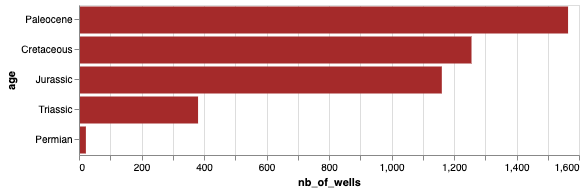

In [54]:
alt.Chart(df_count).mark_bar().encode(
   x = 'nb_of_wells',
   y = alt.Y(
            'age',
            sort=alt.EncodingSortField(
            field='nb_of_wells',  # The field to use for the sort
            op='sum',  # The operation to run on the field prior to sorting
            order='descending'  # The order to sort in
        )
    ),
    color=alt.value('brown')
).properties(height=150, width=500)

---

#### Geospatialisation - converting our dataframe to ultimately a shapefile.

In [55]:
# creating a tuple with long/lat in DD
df_strati_NTS_NS_age_DD = df_strati_NTS_NS_age.copy()

df_strati_NTS_NS_age_DD['Coordinates'] = list(zip(df_strati_NTS_NS_age_DD.wlbEwDesDeg, 
                                                  df_strati_NTS_NS_age_DD.wlbNsDecDeg))

# Tuples to Point
df_strati_NTS_NS_age_DD['Coordinates'] = df_strati_NTS_NS_age_DD['Coordinates'].apply(Point)

# Now, we can create the GeoDataFrame by setting geometry with the coordinates
df_strati_NTS_NS_age_DD = geopandas.GeoDataFrame(df_strati_NTS_NS_age_DD, geometry='Coordinates')

We can now create 2 separate dataframes, one for North Sea wells, and the other for Norwegian Sea wells:

In [56]:
df_strati_NTS_age_DD = df_strati_NTS_NS_age_DD.loc[df_strati_NTS_NS_age_DD.wlbMainArea=='NORTH SEA']
df_strati_NS_age_DD = df_strati_NTS_NS_age_DD.loc[df_strati_NTS_NS_age_DD.wlbMainArea=='NORWEGIAN SEA']

Quick display of the geodataframe with both North Sea and Norwegian Sea - This is to QC the general position of our wells

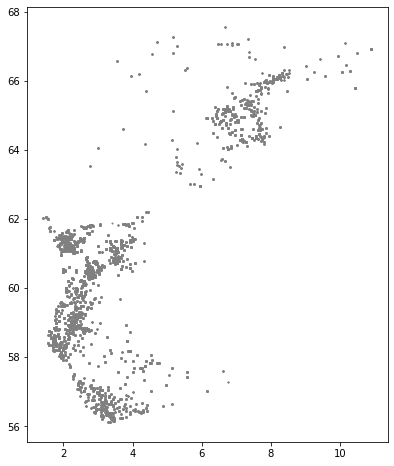

In [57]:
df_strati_NTS_NS_age_DD.plot(figsize=(8,8), color='grey', markersize = 1)

We can now save our dataframe to SHAPEFILE:

In [58]:
# create a shapefile from df_strati_NS_age_DD
# df_strati_NTS_NS_age_DD.to_file('../shapefiles/strati_NS_age_DD.shp',driver ='ESRI Shapefile')

---

### Using MAPBOX

It is now possible to display our shapefile in MAPBOX. Below is an example showing all wells with Triassic. More about MapBox here: www.mapbox.com.

In [59]:
IFrame(src='https://api.mapbox.com/styles/v1/annee/cjtxe6kxk2n9v1fpiqravigpi.html?fresh=true&title=true&access_token=pk.eyJ1IjoiYW5uZWUiLCJhIjoiY2puYng1ZjNlMDU3djN2c2YxdGxqeTk5biJ9.Iq8vP18GcAukiVpWNqJ5Pg#5.2/59.5/5.0/0', width=900, height=700)